In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython.display import clear_output
from keras.layers import *
from tensorflow import keras
from keras.layers.merge import concatenate, add
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import ResNet50

Download the caltech_birds2010 dataset

In [75]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [76]:
# dataset, info = tfds.load('CaltechBirds2010:0.*.*', with_info=True)

# **U_NET:**

# Preprocessing data


In [77]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000

#### put image size ###

image_size = 256

In [78]:
def normalize(input_image, input_mask):
  input_image = input_image/255.
  input_mask = input_mask / 255.
  return input_image, input_mask




**Complete the required items:**

Flip images from right to left

Flip images from up to down

adjust brightness image with delta = 0.5

central crop image with value = 0.5

In [79]:
@tf.function
def load_image_train(datapoint):
  #Resize
  
  input_image = tf.image.resize(datapoint['image'], [image_size,image_size])
  input_mask = tf.image.resize(datapoint['segmentation_mask'], [image_size,image_size])
  if tf.random.uniform(()) > 0.5:
    

    #### put your code ###
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

    input_image = tf.image.flip_up_down(input_image)
    input_mask = tf.image.flip_up_down(input_mask)

    input_image = tf.image.adjust_brightness(input_image, delta=0.5)
    input_mask = tf.image.adjust_brightness(input_mask, delta=0.5)

    input_image = tf.image.central_crop(input_image, 0.5)
    input_mask = tf.image.central_crop(input_mask, 0.5)

    input_image = tf.image.resize(input_image, [image_size,image_size])
    input_mask = tf.image.resize(input_mask, [image_size,image_size])
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [80]:
def load_image_test(datapoint):
  #Resize
  
  input_image = tf.image.resize(datapoint['image'], [image_size,image_size])
  input_mask = tf.image.resize(datapoint['segmentation_mask'], [image_size,image_size])


  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [81]:

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [82]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if i>0:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]),cmap='gray')
    else:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

(256, 256, 3)
(256, 256, 1)
(256, 256, 3)
(256, 256, 1)
(256, 256, 3)
(256, 256, 1)
(256, 256, 3)
(256, 256, 1)
(256, 256, 3)
(256, 256, 1)
(256, 256, 3)
(256, 256, 1)


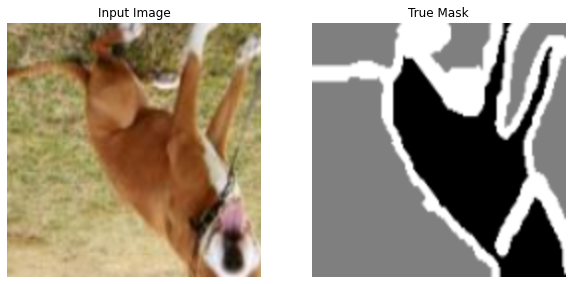

In [83]:
for image, mask in train.take(6):
  print(image.shape)
  print(mask.shape)
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

# U-net architecture

Encoder | Bottleneck | Decoder
--- | --- | ---
START:| | TS(1,4,2)
CL(32,4,2) |  | TBR(32,4,2)
CBL(64,4,2) |  | TBDR(64,4,2)
CBL(128,4,2) |  | TBR(128,4,2)
CBL(256,4,2) |  | TBDR(256,4,2)
CBL(512,4,2) | CR(512,4,2) | TBDR(512,4,2)


 Acronyms: C=convolution, B=batch normalization, L= leaky relu(alpha=0.1.5), D=dropout, R=relu,
T=transpose convolution, S=sigmoid. 

The numbers in parentheses indicate the number of ﬁlters, ﬁlter size, and stride of the convolution
ﬁlters, respectively.

Initialize weights with mean=0 and Standard deviation=0.02

You can use the following link to get acquainted with convolution2d_transpose


https://keras.io/api/layers/convolution_layers/convolution2d_transpose/

In [84]:
# define an U_Net
inputs = keras.layers.Input(shape=(256, 256, 3))
def cl(input, num_filters, filter_size, stride):
  initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.02)
  conv = keras.layers.Conv2D(filters=num_filters, kernel_size=filter_size, strides=stride, kernel_initializer=initializer, padding="same", activation=keras.layers.LeakyReLU(alpha=0.15))(input)
  return conv

def cbl(input, num_filters, filter_size, stride):
  initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.02)
  conv = keras.layers.Conv2D(filters=num_filters, kernel_size=filter_size, strides=stride, kernel_initializer=initializer, padding="same", activation=keras.layers.LeakyReLU(alpha=0.15))(input)
  bn = keras.layers.BatchNormalization()(conv)
  return bn

def cr(input, num_filters, filter_size, stride):
  initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.02)
  conv = keras.layers.Conv2D(filters=num_filters, kernel_size=filter_size, strides=stride, kernel_initializer=initializer, padding="same", activation='relu')(input)
  return conv
def tbdr(input, num_filters, filter_size, stride):
  initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.02)
  conv_trans = keras.layers.Conv2DTranspose(filters=num_filters, kernel_size=filter_size, strides=stride, kernel_initializer=initializer, padding="same", activation='relu')(input)
  bn = keras.layers.BatchNormalization()(conv_trans)
  dropout = keras.layers.Dropout(0.2)(bn)
  return dropout

def tbr(input, num_filters, filter_size, stride):
  initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.02)
  conv_trans = keras.layers.Conv2DTranspose(filters=num_filters, kernel_size=filter_size, strides=stride, kernel_initializer=initializer, padding="same", activation='relu')(input)
  bn = keras.layers.BatchNormalization()(conv_trans)
  
  # relu = keras.layers.ReLU()(bn)
  return bn

def ts(input, num_filters, filter_size, stride):
  initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.02)
  conv_trans = keras.layers.Conv2DTranspose(filters=num_filters, kernel_size=filter_size, strides=stride, kernel_initializer=initializer, padding="same", activation='sigmoid')(input)
  # sigmoid = keras.activations.sigmoid()(conv_trans)
  return conv_trans
def unet(input):
  cl0 = cl(input, 32, 4, 2)
  cbl1 = cbl(cl0, 64, 4, 2)
  
  cbl2 = cbl(cbl1, 128, 4, 2)
  cbl3 = cbl(cbl2, 256, 4, 2)
  cbl4 = cbl(cbl3, 512, 4, 2)
  cr5 = cr(cbl4, 512, 4, 2)
  tbdr6 = tbdr(cr5, 512, 4, 2)
  concat7 = concatenate([tbdr6, cbl4])
  tbdr8 = tbdr(concat7, 256, 4, 2)
  concat9 = concatenate([tbdr8, cbl3])
  tbr10 = tbr(concat9, 128, 4, 2)
  concat11 = concatenate([tbr10, cbl2])
  tbdr12 = tbdr(concat11, 64, 4, 2)
  concat13 = concatenate([tbdr12, cbl1])
  tbr14 = tbr(concat13, 32, 4, 2)
  concat15 = concatenate([tbr14, cl0])
  output = ts(concat15, 1, 4, 2)
  model = keras.models.Model(inputs=input, outputs=output)
  return model

In [85]:
input = keras.layers.Input((image_size, image_size, 3), name='img')
U_Net = unet(input)


# Compile:

Use Adam optimizer with learning rate 0.001 and BinaryCrossentropy with from_logits=True

Set accuracy for metrics 

In [86]:
#Compile
U_Net.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=["accuracy"])
U_Net.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_63 (Conv2D)             (None, 128, 128, 32  1568        ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 conv2d_64 (Conv2D)             (None, 64, 64, 64)   32832       ['conv2d_63[0][0]']              
                                                                                            

# Fit the model

In [87]:

EPOCHS = 30
VAL_SUBSPLITS = 5 
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE


#Complete with train_data, epochs, steps_per_epoch, validation_steps, validation_data
history = U_Net.fit(train_dataset, epochs=EPOCHS, validation_steps=VALIDATION_STEPS, validation_data=test_dataset, steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/30
57/57 [==============================] - 51s 783ms/step - loss: 0.2909 - accuracy: 0.0000e+00 - val_loss: 0.2088 - val_accuracy: 0.0000e+00
Epoch 2/30
57/57 [==============================] - 44s 775ms/step - loss: 0.0443 - accuracy: 0.0000e+00 - val_loss: 0.0640 - val_accuracy: 0.0000e+00
Epoch 3/30
57/57 [==============================] - 44s 770ms/step - loss: 0.0440 - accuracy: 0.0000e+00 - val_loss: 0.0502 - val_accuracy: 0.0000e+00
Epoch 4/30
57/57 [==============================] - 44s 770ms/step - loss: 0.0441 - accuracy: 0.0000e+00 - val_loss: 0.0463 - val_accuracy: 0.0000e+00
Epoch 5/30
57/57 [==============================] - 44s 769ms/step - loss: 0.0440 - accuracy: 0.0000e+00 - val_loss: 0.0444 - val_accuracy: 0.0000e+00
Epoch 6/30
57/57 [==============================] - 44s 769ms/step - loss: 0.0440 - accuracy: 0.0000e+00 - val_loss: 0.0434 - val_accuracy: 0.0000e+00
Epoch 7/30
57/57 [==============================] - 44s 770ms/step - loss: 0.0440 - accuracy: 

# Predict


In [88]:
def show_predictions(dataset, num=10):
  for image, mask in dataset.take(num):
      #Prediction
      pred_mask = U_Net.predict(image) 
      display([image[0], mask[0], pred_mask[0]])

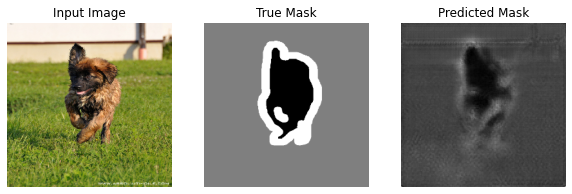

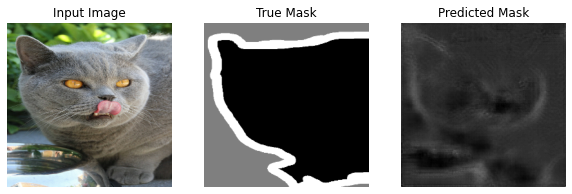

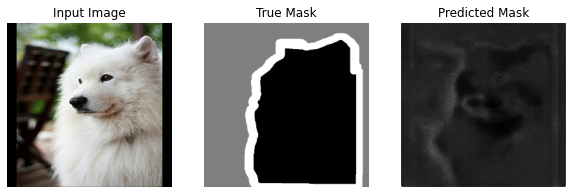

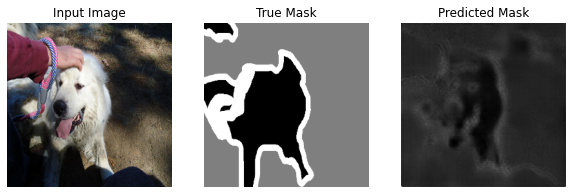

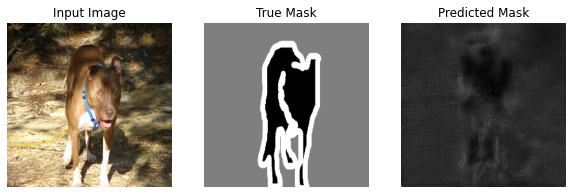

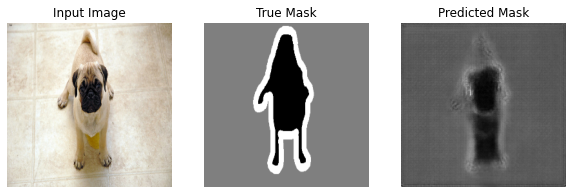

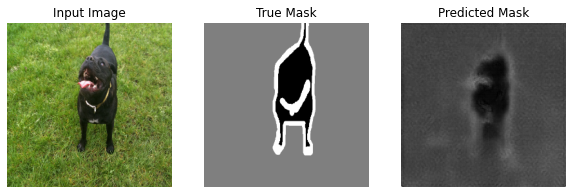

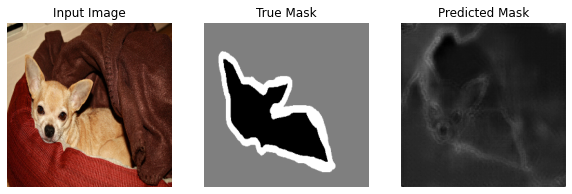

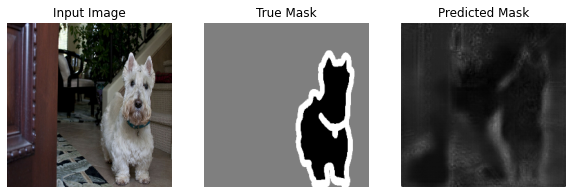

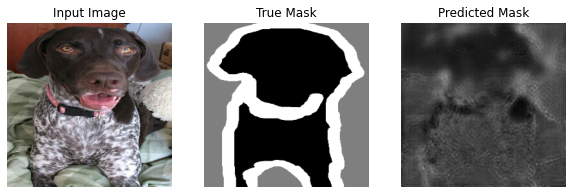

In [89]:
show_predictions(test_dataset)

# **D_LinkNet:**

# Preprocessing data


In [50]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000

#### put image size ###

image_size = 256

In [51]:
def normalize(input_image, input_mask):
  input_image = input_image/255.
  input_mask = input_mask / 255.
  return input_image, input_mask




**Complete the required items:**

Flip images from right to left

Flip images from up to down

adjust brightness image with delta = 0.5

central crop image with value = 0.5

In [52]:
@tf.function
def load_image_train(datapoint):
  #Resize
  
  input_image = tf.image.resize(datapoint['image'], [image_size,image_size])
  input_mask = tf.image.resize(datapoint['segmentation_mask'], [image_size,image_size])
  if tf.random.uniform(()) > 0.5:
    

    #### put your code ###
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

    input_image = tf.image.flip_up_down(input_image)
    input_mask = tf.image.flip_up_down(input_mask)

    input_image = tf.image.adjust_brightness(input_image, delta=0.5)
    input_mask = tf.image.adjust_brightness(input_mask, delta=0.5)

    input_image = tf.image.central_crop(input_image, 0.5)
    input_mask = tf.image.central_crop(input_mask, 0.5)

    input_image = tf.image.resize(input_image, [image_size,image_size])
    input_mask = tf.image.resize(input_mask, [image_size,image_size])

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [53]:
def load_image_test(datapoint):
  #Resize
  
  input_image = tf.image.resize(datapoint['image'], [image_size,image_size])
  input_mask = tf.image.resize(datapoint['segmentation_mask'], [image_size,image_size])

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [54]:

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [55]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if i>0:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]),cmap='gray')
    else:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

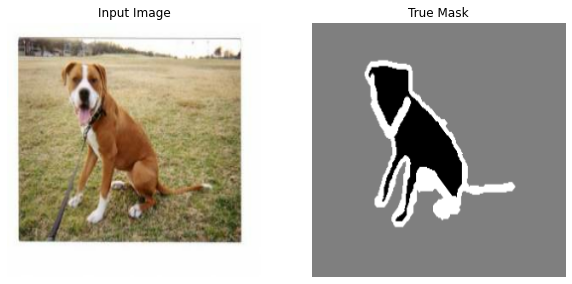

In [56]:
for image, mask in train.take(6):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

# D_linknet architecture:

https://sci-hub.se/10.1109/CVPRW.2018.00034



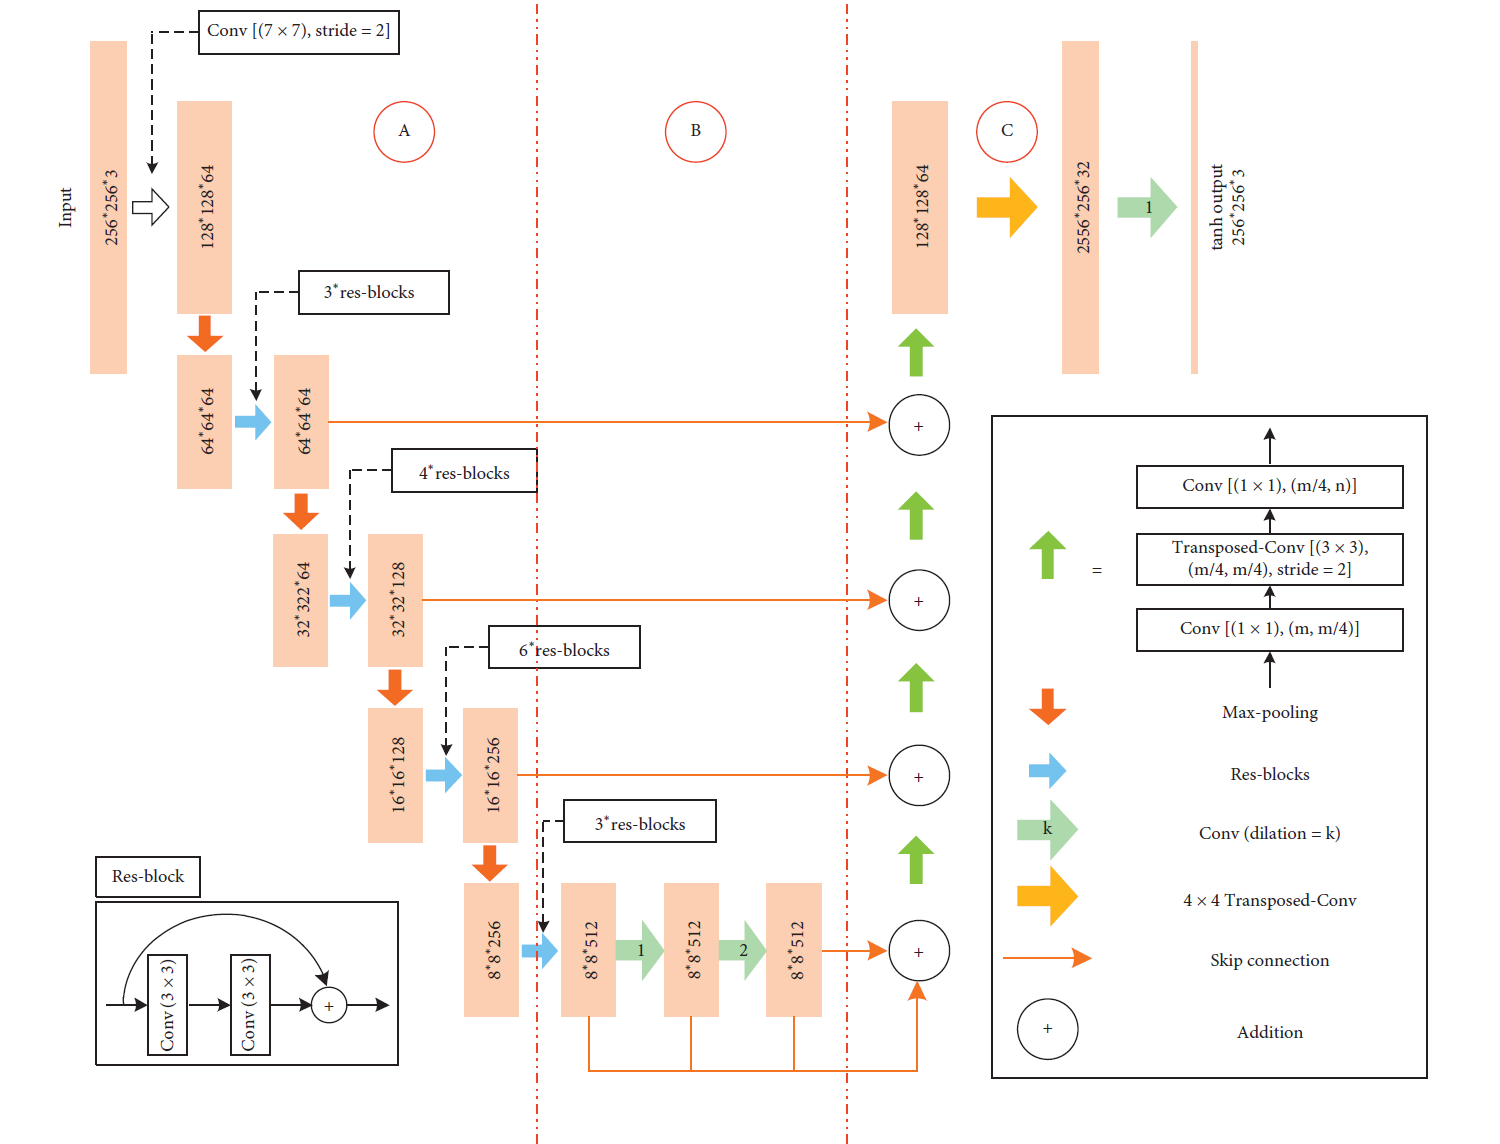


You can use the following link to get acquainted with convolution2d_transpose


https://keras.io/api/layers/convolution_layers/convolution2d_transpose/


In [57]:

# define a D_linknet
input = keras.layers.Input((256, 256, 3))
resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=input)
# resnet50.summary()
# 'conv2_block3_out'
# 'conv3_block4_out'
# 'conv4_block6_out'
# 'conv5_block3_out'


a1 = resnet50.get_layer("conv2_block3_out").output                            ## (64 x 64 x 256)
a1 = keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same', activation='relu')(a1)   ## (64 x 64 x 64)
a2 = resnet50.get_layer("conv3_block4_out").output                            ## (32 x 32 x 512)
a2 = keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same', activation='relu')(a2)  ## (32 x 32 x 128)
a3 = resnet50.get_layer("conv4_block6_out").output                            ## (16 x 16 x 1024)
a3 = keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same', activation='relu')(a3)  ## (16 x 16 x 256)


b1 = resnet50.get_layer("conv5_block3_out").output                            ## (8 x 8 x 2048)
b1 = keras.layers.Conv2D(filters=512, kernel_size=(1,1), padding='same', activation='relu')(b1)  ## (8 x 8 x 512)

b11 = keras.layers.Conv2D(filters=512, kernel_size=(3,3), dilation_rate=(1,1), padding='same', activation='relu')(b1)
b12 = keras.layers.Conv2D(filters=512, kernel_size=(3,3), dilation_rate=(2,2), padding='same', activation='relu')(b11)

c1 = keras.layers.Add()([b1, b11, b12])

c2_c1 = keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same', activation='relu')(c1)
c2_t1 = keras.layers.Conv2DTranspose(filters=64, kernel_size=(3,3), padding='same', activation='relu', strides=2)(c2_c1)
c2_c2 = keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same', activation='relu')(c2_t1)

c3 = keras.layers.Add()([a3, c2_c2])

c4_c1 = keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same', activation='relu')(c3)
c4_t1 = keras.layers.Conv2DTranspose(filters=32, kernel_size=(3,3), padding='same', activation='relu', strides=2)(c4_c1)
c4_c2 = keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same', activation='relu')(c4_t1)

c5 = keras.layers.Add()([a2, c4_c2])

c6_c1 = keras.layers.Conv2D(filters=16, kernel_size=(1,1), padding='same', activation='relu')(c5)
c6_t1 = keras.layers.Conv2DTranspose(filters=16, kernel_size=(3,3), padding='same', activation='relu', strides=2)(c6_c1)
c6_c2 = keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same', activation='relu')(c6_t1)

c7 = keras.layers.Add()([a1, c6_c2])

c8_c1 = keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same', activation='relu')(c7)
c8_t1 = keras.layers.Conv2DTranspose(filters=64, kernel_size=(3,3), padding='same', activation='relu', strides=2)(c8_c1)
c8_c2 = keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same', activation='relu')(c8_t1)

c9 = keras.layers.Conv2DTranspose(filters=32, kernel_size=(4,4), padding='same', activation='relu', strides=2)(c8_c2)
output = keras.layers.Conv2D(filters=1, kernel_size=(3,3), dilation_rate=(1,1), padding='same', activation='tanh')(c9)
Dlinknet = keras.models.Model(inputs=input, outputs=output)

# Compile the model
Use Adam optimizer with learning rate 0.001 and BinaryCrossentropy with from_logits=True

Set accuracy for metrics

In [58]:
#Compile
Dlinknet.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=["accuracy"])
Dlinknet.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

# Fit the model

In [59]:
EPOCHS = 30
VAL_SUBSPLITS = 5 
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

#Complete with train_data, epochs, steps_per_epoch, validation_steps, validation_data
history = Dlinknet.fit(train_dataset, epochs=EPOCHS, validation_steps=VALIDATION_STEPS, validation_data=test_dataset, steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/30
57/57 [==============================] - 168s 3s/step - loss: 0.0547 - accuracy: 0.0000e+00 - val_loss: 0.0425 - val_accuracy: 0.0000e+00
Epoch 2/30
57/57 [==============================] - 148s 3s/step - loss: 0.0440 - accuracy: 0.0000e+00 - val_loss: 0.0425 - val_accuracy: 0.0000e+00
Epoch 3/30
57/57 [==============================] - 142s 2s/step - loss: 0.0440 - accuracy: 0.0000e+00 - val_loss: 0.0425 - val_accuracy: 0.0000e+00
Epoch 4/30
57/57 [==============================] - 142s 2s/step - loss: 0.0440 - accuracy: 0.0000e+00 - val_loss: 0.0425 - val_accuracy: 0.0000e+00
Epoch 5/30
57/57 [==============================] - 142s 2s/step - loss: 0.0440 - accuracy: 0.0000e+00 - val_loss: 0.0424 - val_accuracy: 0.0000e+00
Epoch 6/30
57/57 [==============================] - 142s 2s/step - loss: 0.0440 - accuracy: 0.0000e+00 - val_loss: 0.0424 - val_accuracy: 0.0000e+00
Epoch 7/30
57/57 [==============================] - 142s 2s/step - loss: 0.0440 - accuracy: 0.0000e+00 - v

# Predict


In [60]:
def show_predictions(dataset, num=10):
  for image, mask in dataset.take(num):
      #Prediction
      pred_mask = Dlinknet.predict(image) 
      display([image[0], mask[0], pred_mask[0]])

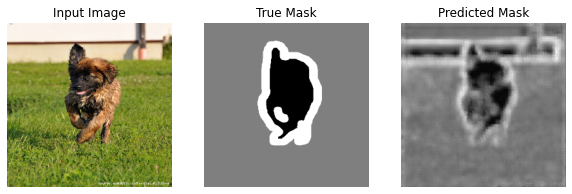

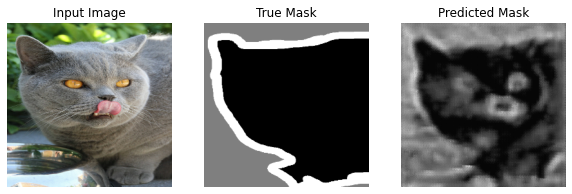

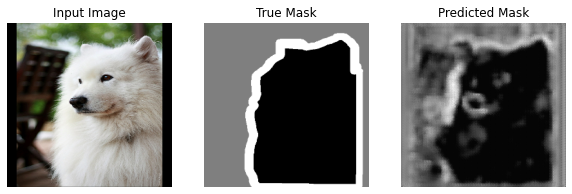

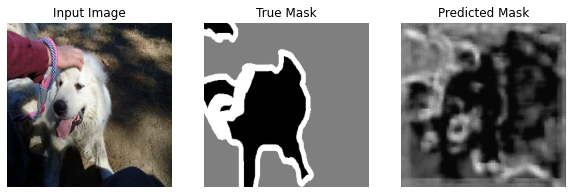

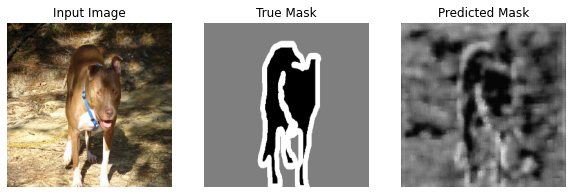

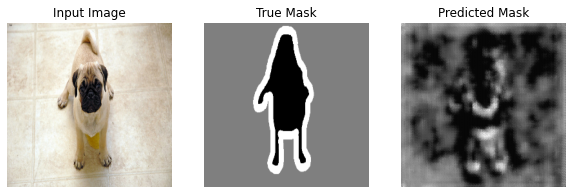

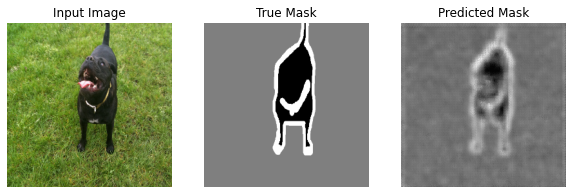

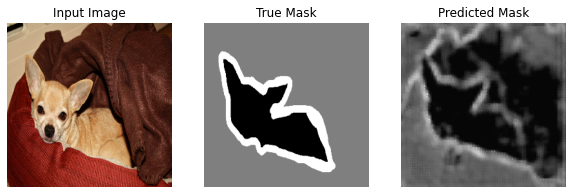

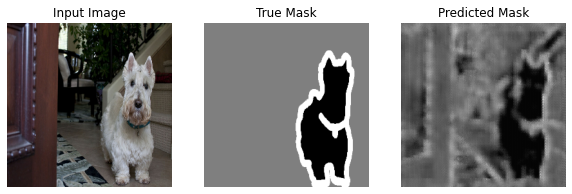

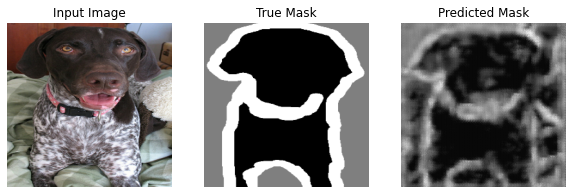

In [61]:
show_predictions(test_dataset)